# Load libraries

In [210]:
import numpy as np
!pip3 install pydub
import pydub
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Converting MP3 to numpy array

In [211]:
def read(f, normalized=False):
    """MP3 to numpy array"""
    a = pydub.AudioSegment.from_mp3(f)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    if normalized:
        return a.frame_rate, np.float32(y) / 2**15
    else:
        return a.frame_rate, y

def write(f, sr, x, normalized=False):
    """numpy array to MP3"""
    channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
    if normalized:  # normalized array - each item should be a float in [-1, 1)
        y = np.int16(x * 2 ** 15)
    else:
        y = np.int16(x)
    song = pydub.AudioSegment(y.tobytes(), frame_rate=sr, sample_width=2, channels=channels)
    song.export(f, format="mp3", bitrate="320k")

# Load music

In [212]:

sample_rate, sample = read('/content/Summertime (Ella Fitzgerald Cover).mp3')
data = sample[1000000:2000000,0]

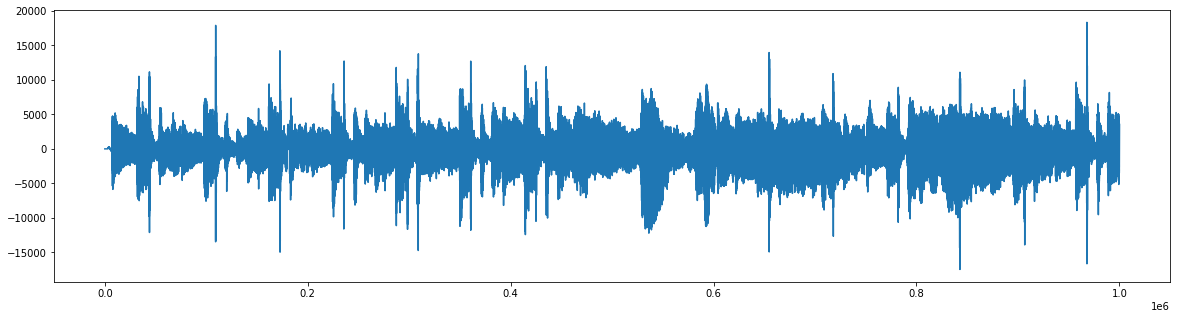

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(data)

# Short Fourier Transform

STFTs can be used as a way of quantifying the change of a nonstationary signal’s frequency and phase content over time.



In [164]:
from scipy  import signal 

def STFT(X,sample_rate,window_length,window,overlap,nfft):
  f, t, Y = signal.stft(X,
                        sample_rate,
                        window =window,
                        nperseg=window_length,
                        noverlap=480*overlap,
                        nfft=nfft)
  Y_mag = np.abs(Y) ## The absolute value causes information loss

  return f,t,Y,Y_mag

def i_STFT(X,sample_rate,window_length,window,overlap,nfft):
  _, Y = signal.istft(X,
                        sample_rate,
                        window =window,
                        nperseg=window_length,
                        noverlap=480*overlap,
                        nfft=nfft)

  return Y

## Calculate the STFT of the mixed signal

In [209]:
f,t,Y,Y_mag = STFT(data,
               sample_rate=sample_rate,
               window_length = 480,
               window="hamming",
               overlap=0.6,
               nfft=512
               ) 


IndexError: ignored

## Reconstruction of the music using the inverse STFT

This step is important because it informs us about the quality of the STFT applied on the data which will be feeded to the NMF algorithm

In [166]:
Y_inv = i_STFT(Y,sample_rate=sample_rate,
               window_length = 480,
               window="hamming",
               overlap=0.6,
               nfft=512)

In [ ]:
### Reconstruction of the STFT

write("test.wav", sample_rate, Y_inv.astype(np.int16))


### Spectrum visualization

In [ ]:
plt.pcolormesh(t, f, Y_mag, vmin=0, vmax=20, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

## NMF

Find two non-negative matrices $(W, H)$ whose product approximates the non- negative matrix X. This factorization will be used  in our case for **source separation** despite the fact that NMF can be used for dimensionality reduction or even topic extraction.

In [168]:
from sklearn.decomposition import NMF

In [169]:
##similarity
n_compnt = 2

model = NMF(n_components=n_compnt,
            init='random',
            beta_loss="itakura-saito",

            max_iter=100,
            random_state=0,
            solver="mu"
)
B = model.fit_transform(Y_mag)
G = model.components_

#### Calculate the score

In [170]:
div = Y_mag / model.inverse_transform(B)
res = np.sum(div) - np.product(Y_mag.shape) - np.sum(np.log(div))
res

340415.03696229355

#### The initial estimate for the first source magnitude spectrogram

In [171]:
def gain(B,G,i):
  source_i =  np.matmul(B[:,i].reshape((B.shape[0],1)),G[i,:].reshape((1,G.shape[1])))
  source_all = np.zeros(shape=(Y.shape[0],Y.shape[1]))

  for k in range(n_compnt):

    source_k =  np.matmul(B[:,k].reshape((B.shape[0],1)),G[k,:].reshape((1,G.shape[1])))
    source_all = np.add(source_k,source_all)

  return source_i / (source_all+0.00001)


### Retrieve the source signal using the  Inverse STFT 

In [172]:
def retrieve_source(index):

  spectrum_source = np.multiply(gain(B,G,index),Y)

  sample_rate2, original_source_sound = signal.istft(spectrum_source,
                      sample_rate,
                      window = "hamming",
                      nperseg=480,
                      noverlap=480*0.6,
                      nfft = 512)
  write("source_{}.wav".format(index), sample_rate, original_source_sound.astype(np.int16))

  return spectrum_source,original_source_sound

In [173]:
spectrum_s1,sound_s1 = retrieve_source(0)
spectrum_s2,sound_s2 = retrieve_source(1)

# Deep learning Part

In [174]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as I

## Network Architecture

In [175]:

class Net(nn.Module):

    def __init__(self,d):
        super(Net, self).__init__()
        self.sigmoid = torch.nn.Sigmoid()
        self.fc1 = nn.Linear(d, 100)  # d is dimension of the input.
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 200)
        self.fc4 = nn.Linear(200,2)
        

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        x = self.sigmoid(self.fc4(x))


        return x

In [176]:
model = Net(d=257)

### DataLoader

In [177]:
from torch.utils.data import Dataset, DataLoader


class AudioDataset(Dataset):
    """Sources dataset."""

    def __init__(self, Y, s1,s2):
        
        self.s1 = torch.tensor(s1)
        self.s2 = torch.tensor(s2)
        self.Y = Y
        
    def __len__(self):
        return self.s1.size()[0]

    def __getitem__(self, idx):
        
        return {'Y':self.Y[idx,:],'s1': self.s1[idx,:], 's2': self.s2[idx,:]}

In [330]:
# load training data in batches
from sklearn.preprocessing import MinMaxScaler 

s1_mag = np.abs(spectrum_s1).astype("float32")
s2_mag = np.abs(spectrum_s2).astype("float32")

s1_mag_scaled = MinMaxScaler().fit_transform(s1_mag).reshape(-1,257)
s2_mag_scaled = MinMaxScaler().fit_transform(s2_mag).reshape(-1,257)
Y_mag_scaled = MinMaxScaler().fit_transform(Y_mag).reshape(-1,257)


dataset=AudioDataset(Y_mag_scaled, s1_mag_scaled, s2_mag_scaled)

print('Number of samples in the audio is {}'.format(len(dataset)))
batch_size = 256
train_loader = DataLoader(dataset, 
                          batch_size=batch_size,
                          shuffle=False, 
                          num_workers=0)

Number of samples in the audio is 5210


## Losses

In [220]:
def gain_params(s1,s2,y):

  l2_s1 = torch.norm(s1.float(),
                2,
                None)  
  l2_s2 = torch.norm(s2.float(),
                2,
                None) 
   
  l2_Y = torch.norm(y.float(),
                2,
                None)

# u is initialized by the l2-norm of the initial NMF source estimate sˆ1 
# divided by the l2-norm of the mixed signal y
  u = torch.div(l2_s1, l2_Y) 

# v is initialized by the same manner
  v = torch.div(l2_s2, l2_Y)

  return u,v

### Cross-entropy like

$$E_{1}(\boldsymbol{x})=\left(1-f_{1}(\boldsymbol{x})\right)^{2}+\left(f_{2}(\boldsymbol{x})\right)^{2}$$ \\
$$E_{2}(\boldsymbol{x})=\left(f_{1}(\boldsymbol{x})\right)^{2}+\left(1-f_{2}(\boldsymbol{x})\right)^{2}$$

In [ ]:
def feed_(x):
   f = model(x)
   f1 = f[:,0] 
   f2 = f[:,1]

   return f1,f2

def energy_1(x_source1):
  f1,f2 = feed_(x_source1)
  e1 = (1 - f1 ).pow(2) + f2.pow(2)

  return e1 

def energy_2(x_source2):

  f1,f2 = feed_(x_source2)
  e2 = f1.pow(2) + (1 - f2 ).pow(2) 

  return e2

### Least squares differences

$$E_{e r r}\left(\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, \boldsymbol{y}, u, v\right)=\left\|u \boldsymbol{x}_{1}+v \boldsymbol{x}_{2}-\boldsymbol{y}\right\|^{2}$$

In [ ]:
def E_err(s1,s2,y):
  u,v = gain_params(s1,s2,y)
  
  return torch.norm(torch.mul(u,s1) + torch.mul(v,s2) - y,'fro',None)

### Nonnegative constraint

Let's consider $\boldsymbol{\theta}=\left(\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, u, v\right)=\left[\theta_{1}, \theta_{2}, \ldots, \theta_{n}\right]$  a vector containing all the unknowns which must all be nonnegative.

$$R(\theta)=(\min (\theta, 0))^{2}$$

In [ ]:
def relu(x):
  return torch.nn.ReLU()(x)

def nonnegative_constraint(s1,s2,y):  
  u,v = gain_params(s1,s2,y)

  u_sum  = torch.sum(relu(u))
  v_sum  = torch.sum(relu(v))
  x1_sum = torch.sum(relu(s1))
  x2_sum = torch.sum(relu(s2))

  total_sum = 1 / (u_sum + v_sum + x1_sum + x2_sum)    #vector containing all the unknowns which must all be nonnegative

  return total_sum 

### Overall loss

$$\begin{aligned} E\left(\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, \boldsymbol{y}, u, v\right) &=E_{1}\left(\boldsymbol{x}_{1}\right)+E_{2}\left(\boldsymbol{x}_{2}\right)+\lambda E_{e r r}\left(\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, \boldsymbol{y}, u, v\right)  + \beta \sum_{i} R\left(\theta_{i}\right) \end{aligned}$$

In [ ]:
def loss(s1,s2,y,l=5,beta=3):

  return energy_1(s1) + energy_2(s2) + l*E_err(s1,s2,y) + beta*nonnegative_constraint(s1,s2,y)

#### test

In [ ]:
#for i, data in train_loader.item():
    #print(loss(data['s1'],data['s2'],data['Y']))

## Optimization

In [ ]:
x1=torch.tensor(np.zeros((20,10)))
x1.requires_grad = True
d = {"model":model.parameters(),"x":x1}
d =list(model.parameters())+[x1]
optimizer = torch.optim.LBFGS(d,lr=1, max_iter=20, tolerance_grad=1e-07)

## Restricted Boltzman Machine for pretraining the network

In [338]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.init as I
from torch.nn import Sigmoid
from torch.autograd import Variable

class RBM(nn.Module):

    def __init__(self,
                 visible_size,
                 hidden_size):
        super(RBM, self).__init__()
        self.input_layer = visible_size
        self.output_layer = hidden_size
        self.dropout = torch.nn.Dropout(0.005)
        
        self.feed = nn.Linear(visible_size, hidden_size,bias=True)  

    def forward(self, x):
        h = Sigmoid()(self.dropout(self.feed(x)))       # x -> h 

        x_reconstructed = (self.dropout(torch.matmul(h,self.feed.weight)))
        
        h_reconstructed = Sigmoid()(self.dropout(self.feed(x_reconstructed)))# h-> x'



        return h, x_reconstructed,h_reconstructed

In [339]:
model = RBM(257, 200)

learning_rate = 0.001
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,weight_decay=0.005)
def KL_divergence(x, y):
    return x* torch.log(x/ y) + (1 - x) * torch.log((1 - x) / (1 - y))
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)


RBM(
  (dropout): Dropout(p=0.005, inplace=False)
  (feed): Linear(in_features=257, out_features=200, bias=True)
)

### Training RBM

In [340]:
loss_s1 = []
loss_s2 = []

for epoch in range(200):  # loop over the dataset multiple times

    running_loss = 0.0
    for i,data in enumerate(train_loader):
        a = model.feed.weight.t()  


        model.zero_grad()     

        h1,x_reconstructed_1,h_reconstructed_1 = model(data['s1'])     ##  calcul x_reconstructed
        loss_1 = -torch.sum(a*(torch.matmul(data['s1'].t(),h1) - torch.matmul(x_reconstructed_1.t(),h_reconstructed_1)))/(data['s1'].shape[0]*data['s1'].shape[1])
        #loss_1 = torch.sum(KL_divergence(data['s1'],x_reconstructed_1))
        loss_1.backward()
        optimizer.step()    ## W -= W - lr*dL/dW

        mse_1 = criterion(data['s1'],x_reconstructed_1)
        loss_s1.append(mse_1)
        model.zero_grad()     


        h2,x_reconstructed_2,h_reconstructed_2 = model(data['s2'])     ##  calcul x_reconstructed
        loss_2 = -torch.sum(a*(torch.matmul(data['s2'].t(),h2) - torch.matmul(x_reconstructed_2.t(),h_reconstructed_2)))/(data['s2'].shape[0]*data['s2'].shape[1])
        #loss_2 = torch.sum(KL_divergence(data['s2'],x_reconstructed_2))

        loss_2.backward()
        optimizer.step()
        mse_2 = criterion(data['s2'],x_reconstructed_2)
        loss_s2.append(mse_2)
        #loss = torch.add(loss_1)#,loss_2)
               ## W* (xh_t - x'_t.  h'_t)
             ## (xh_t - x'_t. h'_t)

    print("loss s1 {} loss s2 {}".format(criterion(data['s1'],x_reconstructed_1),criterion(data['s2'],x_reconstructed_2)))
print('Finished Training')

loss s1 0.20082363486289978 loss s2 0.20076750218868256
loss s1 0.19034864008426666 loss s2 0.1900542974472046
loss s1 0.1809265911579132 loss s2 0.18040253221988678
loss s1 0.17183712124824524 loss s2 0.1712522655725479
loss s1 0.16319185495376587 loss s2 0.16302995383739471
loss s1 0.1549435406923294 loss s2 0.15511012077331543
loss s1 0.14758402109146118 loss s2 0.14724695682525635
loss s1 0.14045177400112152 loss s2 0.14018799364566803
loss s1 0.1335170865058899 loss s2 0.13362638652324677
loss s1 0.1273077130317688 loss s2 0.1273527294397354
loss s1 0.12152710556983948 loss s2 0.12131498754024506
loss s1 0.1157352477312088 loss s2 0.11573557555675507
loss s1 0.11055909842252731 loss s2 0.11025246977806091
loss s1 0.10543923825025558 loss s2 0.10541003942489624
loss s1 0.10065742582082748 loss s2 0.10059381276369095
loss s1 0.09626647084951401 loss s2 0.09593871235847473
loss s1 0.09191471338272095 loss s2 0.09192672371864319
loss s1 0.08788473904132843 loss s2 0.08773981034755707


In [341]:
def reconstructed_x(X):
      X_torch = torch.from_numpy(X).float()
      _,x_reconstructed,_ = model(X_torch)
      x_reconstructed_np = x_reconstructed.detach().numpy()
      return x_reconstructed_np
def plot_weight(X):
      X_torch = torch.from_numpy(X).float()
      _,x_reconstructed,_ = model(X_torch)
      x_reconstructed_np = x_reconstructed.detach().numpy()
      sns.set(rc={'figure.figsize':(20,8.27)})
      sns.set_style("dark")

      g =sns.distplot(X)
      g =sns.distplot(x_reconstructed_np)
      plt.legend(labels=['Data Distribution','Reconstructed Data Distribution'])
      plt.suptitle("KL Divergence Loss = {} ".format(torch.nn.KLDivLoss()(X_torch,x_reconstructed)))
      plt.show(g)

In [336]:
s1_mag_scaled.max() ,spectra_s1.max()

(1.0000001, 0.7864192)

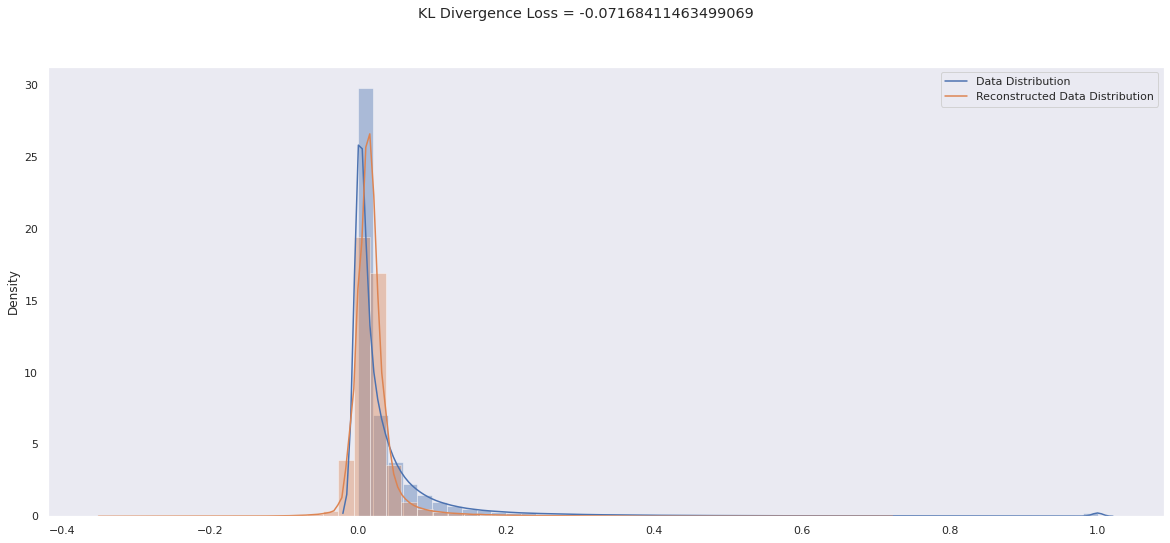

In [342]:
plot_weight(s1_mag_scaled)

## Normalized spectrum 1  | reconstruction of the normalized spectrum of source 1

In [343]:
s1_mag_scaled_ = s1_mag_scaled.reshape(-1,5210)
reconstructed_spectra = reconstructed_x(s1_mag_scaled).reshape(-1,5210)


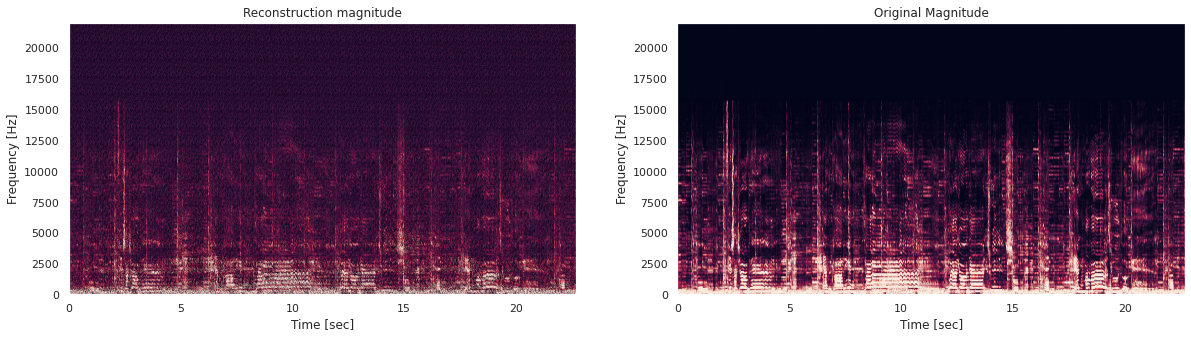

In [367]:
fig , (ax1,ax2) = plt.subplots(1,2,figsize=(20,5))


ax1.pcolormesh(t, f,reconstructed_spectra , vmin=0, vmax=0.1, shading='gouraud')
ax1.set_title('Reconstruction magnitude')
ax1.set_ylabel('Frequency [Hz]')
ax1.set_xlabel('Time [sec]')

ax2.pcolormesh(t, f,s1_mag_scaled_ , vmin=0, vmax=0.2, shading='gouraud')
ax2.set_title('Original Magnitude')
ax2.set_ylabel('Frequency [Hz]')
ax2.set_xlabel('Time [sec]')

plt.show()

In [369]:
torch.nn.KLDivLoss()(torch.from_numpy(s1_mag_scaled_).float(),
                     torch.from_numpy(reconstructed_spectra).float())

tensor(-0.0717)

## Normalized spectrum 2  | reconstruction of the normalized spectrum of source 2

In [359]:
s2_mag_scaled_ = s2_mag_scaled.reshape(-1,5210)
reconstructed_spectra_2 = reconstructed_x(s2_mag_scaled).reshape(-1,5210)


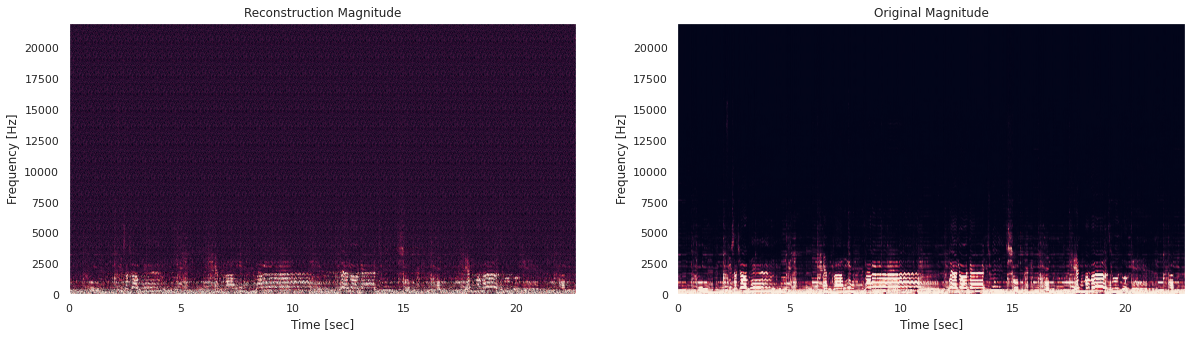

In [366]:
fig , (ax1,ax2) = plt.subplots(1,2,figsize=(20,5))


ax1.pcolormesh(t, f,reconstructed_spectra_2 , vmin=0, vmax=0.1, shading='gouraud')
ax1.set_title('Reconstruction Magnitude')
ax1.set_ylabel('Frequency [Hz]')
ax1.set_xlabel('Time [sec]')

ax2.pcolormesh(t, f,s2_mag_scaled_ , vmin=0, vmax=0.2, shading='gouraud')
ax2.set_title('Original Magnitude')
ax2.set_ylabel('Frequency [Hz]')
ax2.set_xlabel('Time [sec]')

plt.show()